In [ ]:
# =========================================
# MIMIC-IV: AKI causal inference with Notes (LLM hook, single-file)
# =========================================
from __future__ import annotations

# Imports
import os, re, json, time, math, datetime as dt
import numpy as np
import pandas as pd
from google.colab import drive
import statsmodels.api as sm
import matplotlib.pyplot as plt
from pathlib import Path
from sklearn.linear_model import LogisticRegression
import gc

In [ ]:
#!pip install lifelines

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 349.3/349.3 kB 6.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 117.2/117.2 kB 15.5 MB/s eta 0:00:00
  Created wheel for autograd-gamma: filename=autograd_gamma-0.5.0-py3-none-any.whl size=4030 sha256=bcd1df76fb8b7a2d5915d1390794276134b4d542ac536ce3d8efd3121df4e9b5
  Stored in directory: /root/.cache/pip/wheels/50/37/21/0a719b9d89c635e89ff24bd93b862882ad675279552013b2fb
Successfully built autograd-gamma


In [ ]:
try:
    from lifelines import CoxPHFitter
except Exception:
    CoxPHFitter = None

In [ ]:
!pip install python-dotenv -q
from dotenv import load_dotenv
from __future__ import annotations

In [ ]:
drive.mount('/content/drive')
drive_path = '/content/drive/MyDrive/'
load_dotenv(drive_path + 'Colab Notebooks/env_config/.env')

Mounted at /content/drive


True

In [ ]:
# ---------- Config ----------
pd.set_option("display.max_rows", 8)
MIMIC_DIR = Path("/content/drive/MyDrive/data/mimiciv/3.1/")  # <- 경로 맞게 수정
HOSP = MIMIC_DIR / "hosp"
NOTE = MIMIC_DIR / "note"
OUTD = Path("/content/drive/MyDrive/results_ci"); OUTD.mkdir(parents=True, exist_ok=True)

# 큰 csv.gz는 청크로
READ_KW = dict(dtype_backend="pyarrow", low_memory=False)

# Causal / modeling
RANDOM_STATE   = 7
PS_CLIP        = (1e-3, 1-1e-3)
W_TRIM         = (0.01, 0.99)
VPT_WINDOW_HOURS = 6
COX_PENALIZER  = 0.1

# Regex / patterns
RX_SCR_LABEL = "creatinine"                  # simple substring (no regex)
RX_SCR_FLUID = r"\b(?:serum|blood)\b"        # regex
RX_MGDL      = r"\bmg/dl\b"
RX_MGL       = r"\bmg/l\b"
RX_VANCO_SUB = "vancomycin"
RX_PTZ       = r"(?:piperacillin|tazobactam|zosyn)"
RX_EMERG_SUB = "EMER"

# LLM confounders (배치 출력이 제공하는 키)
CONFOUNDERS = ["f_ckd_pre", "f_dm_pre", "f_hf_pre", "f_liver_pre", "f_nephrotox_pre"]

In [ ]:
# =========================
# Utils
# =========================
def _to_datetime_safe(s: pd.Series, fmt: str | None = "%Y-%m-%d %H:%M:%S") -> pd.Series:
    x = pd.to_datetime(s, errors="coerce", format=fmt)
    if x.isna().any():
        y = pd.to_datetime(s[x.isna()], errors="coerce")
        x.loc[x.isna()] = y
    return x

def _smd(x, t, w=None):
    x = np.asarray(x, float); t = np.asarray(t, int)
    if w is None: w = np.ones_like(t, float)
    if (t==1).sum()==0 or (t==0).sum()==0: return np.nan
    m1 = np.average(x[t==1], weights=w[t==1]); m0 = np.average(x[t==0], weights=w[t==0])
    v1 = np.average((x[t==1]-m1)**2, weights=w[t==1]); v0 = np.average((x[t==0]-m0)**2, weights=w[t==0])
    return (m1-m0)/np.sqrt((v1+v0)/2 + 1e-9)

def evalue_from_hr(hr, lcl, ucl):
    def _ev(x: float) -> float:
        return x + math.sqrt(max(x,0)*(max(x,0)-1.0)) if x>1 else 1.0
    return (_ev(float(hr)), _ev(float(lcl)) if float(lcl)>1 else 1.0)

In [ ]:
# =========================
# 1) Treatment cohort (V vs VPT)
# =========================
def build_cohort(hosp: Path) -> pd.DataFrame:
    use_cols = ["subject_id","hadm_id","starttime","stoptime","drug"]
    it = pd.read_csv(hosp/"prescriptions.csv.gz",
                     usecols=lambda c: c in use_cols,
                     chunksize=500_000, low_memory=False)
    v_chunks, p_chunks = [], []

    for ch in it:
        ch["starttime"] = _to_datetime_safe(ch["starttime"])
        ch["stoptime"]  = _to_datetime_safe(ch["stoptime"])
        dlow = ch["drug"].astype("string").str.lower()

        v = ch[dlow.str.contains(RX_VANCO_SUB, na=False, regex=False)]
        p = ch[dlow.str.contains(RX_PTZ,       na=False, regex=True)]

        v = v.rename(columns={"starttime":"v_start","stoptime":"v_stop"})
        p = p.rename(columns={"starttime":"p_start","stoptime":"p_stop"})
        v_chunks.append(v[["subject_id","hadm_id","v_start","v_stop"]])
        p_chunks.append(p[["subject_id","hadm_id","p_start","p_stop"]])

    vanco = pd.concat(v_chunks, ignore_index=True) if v_chunks else \
            pd.DataFrame(columns=["subject_id","hadm_id","v_start","v_stop"])
    ptz   = pd.concat(p_chunks, ignore_index=True) if p_chunks else \
            pd.DataFrame(columns=["subject_id","hadm_id","p_start","p_stop"])

    v1 = (vanco.sort_values("v_start")
                .groupby(["subject_id","hadm_id"], as_index=False)
                .agg(index_time=("v_start","first")))
    p1 = (ptz.sort_values("p_start")
              .groupby(["subject_id","hadm_id"], as_index=False)
              .agg(ptz_time=("p_start","first")))

    v1["index_time"] = _to_datetime_safe(v1["index_time"])
    p1["ptz_time"]   = _to_datetime_safe(p1["ptz_time"])

    cohort = v1.merge(p1, how="left", on=["subject_id","hadm_id"])
    cohort = cohort.dropna(subset=["index_time"]).reset_index(drop=True)

    # STRICT: ptz_time within +6h
    cohort["vpt_flag"] = (
        cohort["ptz_time"].notna() &
        (cohort["ptz_time"] >= cohort["index_time"]) &
        (cohort["ptz_time"] <= cohort["index_time"] + pd.Timedelta(hours=VPT_WINDOW_HOURS))
    ).astype(int)

    for k in ("subject_id","hadm_id"):
        cohort[k] = cohort[k].astype("Int64")

    print(f"[cohort] N={len(cohort)}  VPT={int(cohort['vpt_flag'].sum())}")
    return cohort

In [ ]:
# =========================
# 2) Labs → SCr & AKI labels
# =========================
def load_scr_itemids(hosp: Path) -> list[int]:
    d_lab = pd.read_csv(hosp/"d_labitems.csv.gz", **READ_KW)
    mask = (
        d_lab["label"].astype("string").str.contains(RX_SCR_LABEL, na=False, regex=False, case=False) &
        d_lab["fluid"].astype("string").str.contains(RX_SCR_FLUID, na=False, regex=True, case=False)
    )
    ids = d_lab.loc[mask, "itemid"].dropna().astype("Int64").astype(int).unique().tolist()
    if len(ids) == 0:
        mask2 = d_lab["label"].astype("string").str.contains(RX_SCR_LABEL, na=False, regex=False, case=False)
        ids = d_lab.loc[mask2, "itemid"].dropna().astype("Int64").astype(int).unique().tolist()

    print(f"[scr ids] K={len(ids)}  sample: {ids[:3]}")
    return ids

def load_scr_timeseries(hosp: Path, cohort: pd.DataFrame, scr_ids: list[int]) -> pd.DataFrame:
    if len(scr_ids)==0:
        raise RuntimeError("No SCr itemids found. Check d_labitems.csv.gz filters.")

    hadm_set = set(cohort["hadm_id"].dropna().astype(int).unique().tolist())
    keep = ["subject_id","hadm_id","itemid","charttime","valuenum","valueuom"]

    it = pd.read_csv(hosp/"labevents.csv.gz",
                     usecols=lambda c: c in keep,
                     chunksize=1_000_000, low_memory=False)
    chunks=[]
    for ch in it:
        ch = ch[ch["itemid"].isin(scr_ids)]
        ch = ch[ch["hadm_id"].isin(hadm_set)]
        if len(ch)==0:
            continue
        ch["charttime"] = _to_datetime_safe(ch["charttime"])

        u = ch["valueuom"].astype("string").str.lower()
        ch["scr_mgdl"] = ch["valuenum"]

        m_mgl  = u.str.contains(RX_MGL,  na=False, regex=True)
        m_mgdl = u.str.contains(RX_MGDL, na=False, regex=True)

        ch.loc[m_mgl, "scr_mgdl"] = ch.loc[m_mgl, "valuenum"] / 10.0
        ch = ch[m_mgdl | m_mgl]
        if len(ch):
            chunks.append(ch[["subject_id","hadm_id","itemid","charttime","scr_mgdl"]])

    df = pd.concat(chunks, ignore_index=True) if chunks else \
         pd.DataFrame(columns=["subject_id","hadm_id","itemid","charttime","scr_mgdl"])

    df = df.merge(cohort[["subject_id","hadm_id","index_time","vpt_flag"]],
                  on=["subject_id","hadm_id"], how="inner")

    if len(df)==0:
        print("[scr ts] rows=0 (no overlapping SCr rows for cohort)")
        return df

    df["index_time"] = _to_datetime_safe(df["index_time"])
    df = df.dropna(subset=["charttime","index_time"]).reset_index(drop=True)
    df["dt"] = (df["charttime"] - df["index_time"]).dt.total_seconds()/3600.0
    df = df.sort_values(["subject_id","hadm_id","charttime"]).reset_index(drop=True)
    for k in ("subject_id","hadm_id"):
        df[k] = df[k].astype("Int64")
    print(f"[scr ts] rows={len(df)}")
    return df

def label_aki(df: pd.DataFrame, cohort: pd.DataFrame) -> pd.DataFrame:
    if len(df)==0:
        out = cohort.copy()
        out["baseline"] = np.nan
        out["aki48"] = 0; out["aki7x"] = 0; out["aki"] = 0
        print(f"[aki] rate=0.000  N={len(out)} (no SCr rows)")
        return out

    base = (df[(df["dt"]>=-24) & (df["dt"]<=0)]
              .groupby(["subject_id","hadm_id"], as_index=False)
              .agg(baseline=("scr_mgdl","median")))
    out = cohort.merge(base, on=["subject_id","hadm_id"], how="left")

    if out["baseline"].isna().any():
        first24 = (df[(df["dt"]>=0) & (df["dt"]<=24)]
                     .sort_values("charttime")
                     .groupby(["subject_id","hadm_id"], as_index=False)
                     .agg(first24=("scr_mgdl","first")))
        out = out.merge(first24, on=["subject_id","hadm_id"], how="left")
        out["baseline"] = out["baseline"].fillna(out["first24"])

    p48 = (df[(df["dt"]>0) & (df["dt"]<=48)]
             .groupby(["subject_id","hadm_id"], as_index=False)
             .agg(max48=("scr_mgdl","max")))
    p7d = (df[(df["dt"]>0) & (df["dt"]<=24*7)]
             .groupby(["subject_id","hadm_id"], as_index=False)
             .agg(max7=("scr_mgdl","max")))

    out = out.merge(p48, on=["subject_id","hadm_id"], how="left") \
             .merge(p7d, on=["subject_id","hadm_id"], how="left")

    out["aki48"] = (out["max48"] >= (out["baseline"] + 0.3)).astype(int)
    out["aki7x"] = (out["max7"]  >= (1.5 * out["baseline"])).astype(int)
    out["aki"]   = ((out["aki48"]==1) | (out["aki7x"]==1)).astype(int)

    print(f"[aki] rate={out['aki'].mean():.3f}  N={len(out)}")
    return out

In [ ]:
# =========================
# 3) Time-to-event window (≤7d)
# =========================
def build_event_times(df_scr: pd.DataFrame, out: pd.DataFrame, hosp: Path) -> pd.DataFrame:
    adm = pd.read_csv(hosp/"admissions.csv.gz",
                      usecols=["subject_id","hadm_id","admittime","dischtime"],
                      parse_dates=["admittime","dischtime"], **READ_KW)
    adm["admittime"] = _to_datetime_safe(adm["admittime"])
    adm["dischtime"] = _to_datetime_safe(adm["dischtime"])

    if len(df_scr)==0:
        evt = out[["subject_id","hadm_id","index_time","vpt_flag"]].copy()
        evt["event_time_48"] = pd.NaT
        evt["event_time_7"]  = pd.NaT
        evt["event_time"]    = pd.NaT
    else:
        tmp48 = (df_scr[(df_scr["dt"]>0) & (df_scr["dt"]<=48)]
                 .merge(out[["subject_id","hadm_id","baseline"]],
                        on=["subject_id","hadm_id"], how="left"))
        hit48 = tmp48[tmp48["scr_mgdl"] >= (tmp48["baseline"] + 0.3)]
        ev48 = (hit48.sort_values("charttime")
                     .groupby(["subject_id","hadm_id"], as_index=False)
                     .first()[["subject_id","hadm_id","charttime"]]
                     .rename(columns={"charttime":"event_time_48"}))

        tmp7 = (df_scr[(df_scr["dt"]>0) & (df_scr["dt"]<=24*7)]
                .merge(out[["subject_id","hadm_id","baseline"]],
                       on=["subject_id","hadm_id"], how="left"))
        hit7 = tmp7[tmp7["scr_mgdl"] >= (1.5 * tmp7["baseline"])]
        ev7 = (hit7.sort_values("charttime")
                   .groupby(["subject_id","hadm_id"], as_index=False)
                   .first()[["subject_id","hadm_id","charttime"]]
                   .rename(columns={"charttime":"event_time_7"}))

        evt = (out[["subject_id","hadm_id","index_time","vpt_flag"]]
               .merge(ev48, how="left")
               .merge(ev7,  how="left"))
        evt["event_time"] = evt[["event_time_48","event_time_7"]].min(axis=1)

    evt = evt.merge(adm, on=["subject_id","hadm_id"], how="left")
    evt["censor_limit"] = evt["index_time"] + pd.Timedelta(days=7)
    evt["censor_time"]  = evt[["dischtime","censor_limit"]].min(axis=1)

    evt = evt.dropna(subset=["index_time","censor_time"]).reset_index(drop=True)
    evt["event_observed"] = (evt["event_time"].notna()) & (evt["event_time"] <= evt["censor_time"])
    evt["duration_days"] = (
        np.where(
            evt["event_observed"],
            (evt["event_time"] - evt["index_time"]).dt.total_seconds(),
            (evt["censor_time"] - evt["index_time"]).dt.total_seconds()
        ) / 86400.0
    ).clip(min=0)

    for k in ("subject_id","hadm_id"):
        evt[k] = evt[k].astype("Int64")

    print(f"[tte] rows={len(evt)} events={int(evt['event_observed'].sum())}")
    return evt

In [ ]:
def run_pipeline_with_batch_features(HOSP: Path, NOTE: Path, df_outputs: pd.DataFrame):
    # 1) Cohort
    cohort = build_cohort(HOSP)

    # 2) Labs → AKI
    scr_ids = load_scr_itemids(HOSP)
    df_scr  = load_scr_timeseries(HOSP, cohort, scr_ids)
    out     = label_aki(df_scr, cohort)

    # 3) TTE
    evt = build_event_times(df_scr, out, HOSP)

    # 4) (변경) 배치 결과에서 confounder 피처 직접 생성
    note_feat = llm_features_from_batch_outputs(df_outputs)

    # 5) Covariates
    dfc = build_covariates(HOSP, out, note_feat)
    dfc = dfc.merge(evt[["subject_id","hadm_id","duration_days","event_observed"]],
                    on=["subject_id","hadm_id"], how="left")
    dfc = dfc.dropna(subset=["vpt_flag","aki","duration_days","event_observed"]).reset_index(drop=True)

    print(f"[analytic] N={len(dfc)}  events={int(dfc['event_observed'].sum())}  treated={int(dfc['vpt_flag'].sum())}")

    # 6) Evaluate BASE vs BASE+LLM
    base_covs = ["age","sexM","is_emerg","baseline"]
    llm_covs  = base_covs + [c for c in CONFOUNDERS if c in dfc.columns]

    m_base = evaluate_covset(dfc, base_covs, "BASE")
    m_llm  = evaluate_covset(dfc, llm_covs,  "BASE+LLM")

    perf = pd.DataFrame([m_base, m_llm])
    perf.to_csv(OUTD/"perf_base_vs_llm.csv", index=False)

    print("\n=== Performance (BASE vs BASE+LLM) ===")
    cols_show = [
        "covset","k_covs",
        "mean_abs_SMD_before","mean_abs_SMD_after",
        "ESS","KS_PS",
        "IPTW_HR","IPTW_LCL","IPTW_UCL",
        "DR_HR","DR_LCL","DR_UCL",
        "Evalue_point","Evalue_CI"
    ]
    print(perf[cols_show])
    print(f"[saved] {OUTD/'perf_base_vs_llm.csv'}")

    return dfc, perf


In [ ]:
# =========================
# 4) Batch outputs → note features (NO LLM calls)
# =========================
def _split_custom_id(custom_id: str) -> tuple[int|None, int|None]:
    """
    기대 형식: '10000032_22595853' → (10000032, 22595853)
    """
    if not isinstance(custom_id, str):
        return (None, None)
    s = custom_id.strip()
    if not s or "_" not in s:
        return (None, None)
    a, b = s.split("_", 1)
    return (int(a), int(b)) if (a.isdigit() and b.isdigit()) else (None, None)

def _parse_json_safely(s: str) -> dict:
    if s is None or not isinstance(s, str) or not s.strip():
        return {}
    t = s.strip()
    # ```json ... ``` 제거
    if t.startswith("```"):
        t = re.sub(r"^```(?:json)?\s*|\s*```$", "", t, flags=re.IGNORECASE|re.DOTALL).strip()
    # json.loads 우선
    try:
        return json.loads(t)
    except Exception:
        pass
    # 중괄호 블럭만 추출해서 재시도
    m = re.search(r"\{.*\}", t, flags=re.DOTALL)
    if m:
        try:
            return json.loads(m.group(0))
        except Exception:
            pass
    return {}

def llm_features_from_batch_outputs(df_outputs: pd.DataFrame) -> pd.DataFrame:
    """
    df_outputs 필요 컬럼:
      - custom_id (형식: '{subject_id}_{hadm_id}')
      - assistant_text (JSON 문자열)
    선택 필터:
      - http_status == 200
      - finish_reason == 'stop'
      - error isna()
    반환: [subject_id, hadm_id] + CONFOUNDERS(0/1)
    """
    need = {"custom_id", "assistant_text"}
    missing = [c for c in need if c not in df_outputs.columns]
    if missing:
        raise ValueError(f"df_outputs missing columns: {missing}")

    df = df_outputs.copy()

    if "http_status" in df.columns:
        df = df[df["http_status"] == 200]
    if "finish_reason" in df.columns:
        df = df[df["finish_reason"].astype(str).str.lower() == "stop"]
    if "error" in df.columns:
        df = df[df["error"].isna()]

    # custom_id → subject/hadm
    sid_hadm = df["custom_id"].apply(_split_custom_id)
    df["subject_id"] = [p[0] for p in sid_hadm]
    df["hadm_id"]    = [p[1] for p in sid_hadm]
    df = df[~df["hadm_id"].isna()].copy()

    df["hadm_id"] = df["hadm_id"].astype("Int64")
    df["subject_id"] = df["subject_id"].astype("Int64")

    # assistant_text → confounders
    feats = []
    for s in df["assistant_text"].astype(str):
        obj = _parse_json_safely(s)
        row = {}
        for k in CONFOUNDERS:
            v = obj.get(k, 0)
            try:
                row[k] = int(v)
            except Exception:
                row[k] = int(bool(v))
        feats.append(row)
    df_feat = pd.DataFrame(feats, index=df.index)

    out = pd.concat([df[["subject_id","hadm_id"]], df_feat], axis=1)

    # (subject, hadm) 중복 시 OR(=max) 집계
    agg = {k: "max" for k in CONFOUNDERS}
    out = (out.groupby(["subject_id","hadm_id"], dropna=False, as_index=False)
            .agg(agg))

    for c in CONFOUNDERS:
        out[c] = out[c].fillna(0).astype(int)

    # 검증
    assert out["hadm_id"].notna().all(), "hadm_id 누락 행 존재"
    return out

In [ ]:
# =========================
# 5) Covariates + PS + Survival
# =========================
def build_covariates(hosp: Path, out: pd.DataFrame, note_feat: pd.DataFrame) -> pd.DataFrame:
    adm = pd.read_csv(hosp/"admissions.csv.gz",
                      usecols=["subject_id","hadm_id","admittime","dischtime","admission_type"],
                      parse_dates=["admittime","dischtime"], **READ_KW)
    pat = pd.read_csv(hosp/"patients.csv.gz",
                      usecols=["subject_id","gender","anchor_age"], **READ_KW)
    adm["admittime"] = _to_datetime_safe(adm["admittime"])
    adm["dischtime"] = _to_datetime_safe(adm["dischtime"])

    dfc = (out.merge(adm, on=["subject_id","hadm_id"], how="left")
              .merge(pat, on="subject_id", how="left")
              .merge(note_feat, on=["subject_id","hadm_id"], how="left"))

    dfc["age"]      = pd.to_numeric(dfc["anchor_age"], errors="coerce")
    dfc["sexM"]     = (dfc["gender"] == "M").astype(int)
    dfc["is_emerg"] = dfc["admission_type"].astype("string") \
                        .str.contains(RX_EMERG_SUB, na=False, regex=False).astype(int)

    for c in CONFOUNDERS:
        if c in dfc.columns: dfc[c] = dfc[c].fillna(0).astype(int)
    return dfc

def fit_ps_and_sw(dfc: pd.DataFrame, covs: list[str],
                  ps_clip=PS_CLIP, w_trim=W_TRIM):
    covs = [c for c in dict.fromkeys(covs) if c in dfc.columns]
    if not covs:
        raise ValueError("No covariates provided to fit_ps_and_sw.")
    X = dfc[covs].copy()
    for c in covs: X[c] = pd.to_numeric(X[c], errors="coerce")
    X = X.fillna(X.median(numeric_only=True))

    T = dfc["vpt_flag"].astype(int)
    ps_model = LogisticRegression(max_iter=400, solver="lbfgs", random_state=RANDOM_STATE)
    ps_model.fit(X, T)
    ps = np.clip(ps_model.predict_proba(X)[:,1], *ps_clip)

    p_t = float(T.mean())
    sw = np.where(T==1, p_t/ps, (1-p_t)/(1-ps))
    lo, hi = np.quantile(sw, w_trim); sw = np.clip(sw, lo, hi)

    ESS = float((sw.sum()**2)/(sw**2).sum())
    return X, ps, sw, ESS

def cox_results_ipw_and_dr(dfc: pd.DataFrame, sw: np.ndarray, covs: list[str], penalizer=COX_PENALIZER):
    if CoxPHFitter is None:
        raise RuntimeError("lifelines is not installed.")
    d = pd.DataFrame({
        "time":  pd.to_numeric(dfc["duration_days"], errors="coerce"),
        "event": dfc["event_observed"].astype(int),
        "treat": dfc["vpt_flag"].astype(int),
        "sw":    sw
    }).dropna(subset=["time","event","treat","sw"])

    if d["event"].sum() == 0:
        raise RuntimeError("No events in TTE window; cannot fit Cox model.")

    cph_w = CoxPHFitter(penalizer=penalizer)
    cph_w.fit(d, duration_col="time", event_col="event", weights_col="sw", robust=True)
    iptw_HR  = float(np.exp(cph_w.params_["treat"]))
    iptw_LCL, iptw_UCL = np.exp(cph_w.confidence_intervals_.loc["treat"].values)

    X = dfc[covs].copy()
    for c in covs: X[c] = pd.to_numeric(X[c], errors="coerce")
    X = X.fillna(X.median(numeric_only=True))
    d2 = pd.concat([d.reset_index(drop=True), X.reset_index(drop=True)], axis=1)

    cph_dr = CoxPHFitter(penalizer=penalizer)
    cph_dr.fit(d2, duration_col="time", event_col="event", weights_col="sw", robust=True)
    dr_HR  = float(np.exp(cph_dr.params_["treat"]))
    dr_LCL, dr_UCL = np.exp(cph_dr.confidence_intervals_.loc["treat"].values)

    return (iptw_HR, iptw_LCL, iptw_UCL), (dr_HR, dr_LCL, dr_UCL)

def evaluate_covset(dfc: pd.DataFrame, covs: list[str], label="BASE"):
    covs = [c for c in dict.fromkeys(covs) if c in dfc.columns]
    if not covs: raise ValueError("No covariates for evaluate_covset.")

    X, ps, sw, ESS = fit_ps_and_sw(dfc, covs)

    T = dfc["vpt_flag"].astype(int).values
    smd_b = [abs(_smd(X[c].values, T, None)) for c in X.columns]
    smd_a = [abs(_smd(X[c].values, T, sw))  for c in X.columns]
    meanSMD_b = float(np.nanmean(smd_b)); meanSMD_a = float(np.nanmean(smd_a))

    # KS(PS overlap)
    try:
        from scipy.stats import ks_2samp
        KS = float(ks_2samp(ps[T==1], ps[T==0]).statistic)
    except Exception:
        grid = np.linspace(0,1,200)
        c1 = np.searchsorted(np.sort(ps[T==1]), grid, side="right")/max(1,(T==1).sum())
        c0 = np.searchsorted(np.sort(ps[T==0]), grid, side="right")/max(1,(T==0).sum())
        KS = float(np.max(np.abs(c1-c0)))

    (hr_i,l_i,u_i),(hr_d,l_d,u_d) = cox_results_ipw_and_dr(dfc, sw, covs)
    E_point, E_CI = evalue_from_hr(hr_i, l_i, u_i)

    return {
        "covset":label, "k_covs":len(covs),
        "mean_abs_SMD_before":meanSMD_b, "mean_abs_SMD_after":meanSMD_a,
        "ESS":ESS, "KS_PS":KS,
        "IPTW_HR":hr_i, "IPTW_LCL":l_i, "IPTW_UCL":u_i, "IPTW_CI_width":u_i-l_i,
        "DR_HR":hr_d,   "DR_LCL":l_d,  "DR_UCL":u_d,  "DR_CI_width":u_d-l_d,
        "Evalue_point":E_point, "Evalue_CI":E_CI
    }


In [ ]:
# =========================
# 6) Main (Batch features only)
# =========================
def run_pipeline_with_batch_features(HOSP: Path, NOTE: Path, df_outputs: pd.DataFrame):
    # 1) Cohort
    cohort = build_cohort(HOSP)

    # 2) Labs → AKI
    scr_ids = load_scr_itemids(HOSP)
    df_scr  = load_scr_timeseries(HOSP, cohort, scr_ids)
    out     = label_aki(df_scr, cohort)

    # 3) TTE
    evt = build_event_times(df_scr, out, HOSP)

    # 4) 배치 결과 → confounder 피처
    note_feat = llm_features_from_batch_outputs(df_outputs)
    print(f"[features] rows={len(note_feat)}  with confounders={CONFOUNDERS}")

    # 5) Covariates
    dfc = build_covariates(HOSP, out, note_feat)
    dfc = dfc.merge(evt[["subject_id","hadm_id","duration_days","event_observed"]],
                    on=["subject_id","hadm_id"], how="left")
    dfc = dfc.dropna(subset=["vpt_flag","aki","duration_days","event_observed"]).reset_index(drop=True)

    print(f"[analytic] N={len(dfc)}  events={int(dfc['event_observed'].sum())}  treated={int(dfc['vpt_flag'].sum())}")

    # 6) Evaluate BASE vs BASE+LLM
    base_covs = ["age","sexM","is_emerg","baseline"]
    llm_covs  = base_covs + [c for c in CONFOUNDERS if c in dfc.columns]

    m_base = evaluate_covset(dfc, base_covs, "BASE")
    m_llm  = evaluate_covset(dfc, llm_covs,  "BASE+LLM")

    perf = pd.DataFrame([m_base, m_llm])
    perf.to_csv(OUTD/"perf_base_vs_llm.csv", index=False)

    print("\n=== Performance (BASE vs BASE+LLM) ===")
    cols_show = [
        "covset","k_covs",
        "mean_abs_SMD_before","mean_abs_SMD_after",
        "ESS","KS_PS",
        "IPTW_HR","IPTW_LCL","IPTW_UCL",
        "DR_HR","DR_LCL","DR_UCL",
        "Evalue_point","Evalue_CI"
    ]
    print(perf[cols_show])
    print(f"[saved] {OUTD/'perf_base_vs_llm.csv'}")

    return dfc, perf

In [ ]:
df_outputs = pd.read_csv("/content/drive/MyDrive/data/mimiciv/3.1/results_ci/causal_inferencebatches_outputs.csv")

In [ ]:
df_outputs

batch_id  \
0       batch_68ac33277ba881908f0432ed60f473e9   
1       batch_68ac33277ba881908f0432ed60f473e9   
2       batch_68ac33277ba881908f0432ed60f473e9   
3       batch_68ac33277ba881908f0432ed60f473e9   
4       batch_68ac33277ba881908f0432ed60f473e9   
...                                        ...   
331788  batch_68ac3626e4d48190aa35489149fa4cab   
331789  batch_68ac3626e4d48190aa35489149fa4cab   
331790  batch_68ac3626e4d48190aa35489149fa4cab   
331791  batch_68ac3626e4d48190aa35489149fa4cab   
331792  batch_68ac3626e4d48190aa35489149fa4cab   

                                        request_id          custom_id  \
0       batch_req_68ac38fdfcf88190afdd4734d0178bec  10000032_22595853   
1       batch_req_68ac38fdf5248190b2e9094e23f2be13  10000032_22841357   
2       batch_req_68ac38fdf678819080f49e041d96fe70  10000032_25742920   
3       batch_req_68ac38fdf81081908d3095c4a15c7ed4  10000032_29079034   
4       batch_req_68ac38fdfbc8819086cbd3b73aa5b354  10000084_23052089   
...                                            ...                ...   
331788  batch_req_68ad280543f48190a25e781cd209a129  11533102_22785311   
331789  batch_req_68ad2805462c8190b36a2d8ac99aecb3  11533102_27365014   
331790  batch_req_68ad28055f4881909bf6ab7417ba2c02  11533102_28939043   
331791  batch_req_68ad28055db881908657709086a412dd  11533102_29936329   
331792  batch_req_68ad2805aa00819083261e6a0ce5029e  11533158_26616882   

        http_status                    api_request_id                   model  \
0               200  09d9c1519aa33749a6511a0199adb022  gpt-4o-mini-2024-07-18   
1               200  b531ba2fd53a746599a35a3e35553099  gpt-4o-mini-2024-07-18   
2               200  da42a4a8fabba835d4e7f07083d4f81d  gpt-4o-mini-2024-07-18   
3               200  51c0a3ea5656d56c8b1301ef64c8d531  gpt-4o-mini-2024-07-18   
4               200  f57a3d858c6d76e70ab21a61781240f0  gpt-4o-mini-2024-07-18   
...             ...                               ...                     ...   
331788          200  059acedf8f1758de5ef62181b5ed9122  gpt-4o-mini-2024-07-18   
331789          200  37e5986cee5fef365601fcc839edd781  gpt-4o-mini-2024-07-18   
331790          200  d1de20de7e1be514215bdf1b5a2da4ef  gpt-4o-mini-2024-07-18   
331791          200  a43a83e7f1bc7675ae528b9c320a581a  gpt-4o-mini-2024-07-18   
331792          200  85e4b8555db7c1337f276ecfb37850c7  gpt-4o-mini-2024-07-18   

       assistant_role                                     assistant_text  \
0           assistant  {\n  "f_ckd_pre": 1,\n  "f_dm_pre": 0,\n  "f_h...   
1           assistant  {\n  "f_ckd_pre": 1,\n  "f_dm_pre": 0,\n  "f_h...   
2           assistant  {\n  "f_ckd_pre": 1,\n  "f_dm_pre": 0,\n  "f_h...   
3           assistant  {\n  "f_ckd_pre": 1,\n  "f_dm_pre": 0,\n  "f_h...   
4           assistant  {\n  "f_ckd_pre": 0,\n  "f_dm_pre": 0,\n  "f_h...   
...               ...                                                ...   
331788      assistant  {\n  "f_ckd_pre": 0,\n  "f_dm_pre": 1,\n  "f_h...   
331789      assistant  {\n  "f_ckd_pre": 0,\n  "f_dm_pre": 1,\n  "f_h...   
331790      assistant  {\n  "f_ckd_pre": 0,\n  "f_dm_pre": 1,\n  "f_h...   
331791      assistant  {\n  "f_ckd_pre": 0,\n  "f_dm_pre": 1,\n  "f_h...   
331792      assistant  {\n  "f_ckd_pre": 1,\n  "f_dm_pre": 0,\n  "f_h...   

       finish_reason  prompt_tokens  completion_tokens  total_tokens  \
0               stop           2521                 53          2574   
1               stop           3424                 53          3477   
2               stop           3459                 53          3512   
3               stop           3381                 53          3434   
4               stop           3009                 53          3062   
...              ...            ...                ...           ...   
331788          stop           4788                 53          4841   
331789          stop           4721                 53          4774   
331790          stop      

In [ ]:
dfc, perf = run_pipeline_with_batch_features(HOSP, NOTE, df_outputs)

[cohort] N=90327  VPT=7822
[scr ids] K=3  sample: [50912, 52024, 52546]
[scr ts] rows=1172668
[aki] rate=0.175  N=90327
[tte] rows=90327 events=15811
[features] rows=331793  with confounders=['f_ckd_pre', 'f_dm_pre', 'f_hf_pre', 'f_liver_pre', 'f_nephrotox_pre']
[analytic] N=90327  events=15811  treated=7822

=== Performance (BASE vs BASE+LLM) ===
     covset  k_covs  mean_abs_SMD_before  mean_abs_SMD_after           ESS  \
0      BASE       4             0.089088            0.017767  90063.509977   
1  BASE+LLM       9             0.100799            0.017629  89869.120563   

      KS_PS   IPTW_HR  IPTW_LCL  IPTW_UCL     DR_HR    DR_LCL    DR_UCL  \
0  0.098516  1.439858  1.389221   1.49234  1.441970  1.390700  1.495131   
1  0.128194  1.399645  1.350395   1.45069  1.402752  1.352899  1.454443   

   Evalue_point  Evalue_CI  
0      2.235679   2.124554  
1      2.147549   2.038270  
[saved] /content/drive/MyDrive/results_ci/perf_base_vs_llm.csv


PS AUC: BASE vs LLM → 0.5625350112049337 vs 0.5854034740710027
PS KS:  BASE vs LLM → 0.09851579778425834 vs 0.12819418009129901
ESS(LLM): 89869.12056348818


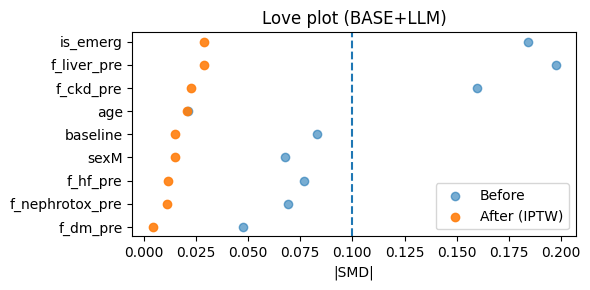

In [ ]:
import numpy as np, pandas as pd
from sklearn.metrics import roc_auc_score, brier_score_loss
import matplotlib.pyplot as plt

# ① 공변량별 SMD(before/after) 계산
def smd_table(dfc, covs, sw=None):
    def _smd(x, t, w=None):
        x=np.asarray(x,float); t=np.asarray(t,int); w=np.ones_like(t,float) if w is None else np.asarray(w,float)
        m1=np.average(x[t==1],weights=w[t==1]); m0=np.average(x[t==0],weights=w[t==0])
        v1=np.average((x[t==1]-m1)**2,weights=w[t==1]); v0=np.average((x[t==0]-m0)**2,weights=w[t==0])
        return (m1-m0)/np.sqrt((v1+v0)/2+1e-9)
    T = dfc["vpt_flag"].astype(int).values
    W = None if sw is None else sw
    rows=[]
    for c in covs:
        if c not in dfc.columns: continue
        x = pd.to_numeric(dfc[c], errors="coerce").fillna(dfc[c].median())
        b = abs(_smd(x, T, None))
        a = abs(_smd(x, T, W))
        rows.append({"covariate":c, "SMD_before":b, "SMD_after":a})
    return pd.DataFrame(rows).sort_values("SMD_after")

# ② PS 진단(AUC, Brier, KS)
from sklearn.linear_model import LogisticRegression
from scipy.stats import ks_2samp

def ps_diagnostics(dfc, covs):
    X = dfc[covs].apply(pd.to_numeric, errors="coerce").fillna(dfc[covs].median(numeric_only=True))
    y = dfc["vpt_flag"].astype(int).values
    m = LogisticRegression(max_iter=400, solver="lbfgs", random_state=7).fit(X, y)
    ps = m.predict_proba(X)[:,1]
    auc = roc_auc_score(y, ps)
    bs  = brier_score_loss(y, ps)
    ks  = ks_2samp(ps[y==1], ps[y==0]).statistic
    return ps, {"AUC":auc, "Brier":bs, "KS":ks}

# 사용 예시 (당신 코드의 covset과 동일하게)
base_covs = ["age","sexM","is_emerg","baseline"]
llm_covs  = base_covs + ["f_ckd_pre","f_dm_pre","f_hf_pre","f_liver_pre","f_nephrotox_pre"]

# BASE
ps_base, diag_base = ps_diagnostics(dfc, base_covs)
smd_base = smd_table(dfc, base_covs, sw=None)

# BASE+LLM (IPTW용 가중치 재계산 필요 시, 당신의 fit_ps_and_sw 사용)
from math import inf
_, ps_llm, sw_llm, ESS_llm = fit_ps_and_sw(dfc, llm_covs)
_, diag_llm = ps_diagnostics(dfc, llm_covs)
smd_llm_w = smd_table(dfc, llm_covs, sw=sw_llm)

print("PS AUC: BASE vs LLM →", diag_base["AUC"], "vs", diag_llm["AUC"])
print("PS KS:  BASE vs LLM →", diag_base["KS"],  "vs", diag_llm["KS"])
print("ESS(LLM):", ESS_llm)

# 간단 Love plot (after)
plt.figure(figsize=(6, max(3, len(smd_llm_w)*0.25)))
y = np.arange(len(smd_llm_w))
plt.scatter(smd_llm_w["SMD_before"], y, label="Before", alpha=0.6)
plt.scatter(smd_llm_w["SMD_after"],  y, label="After (IPTW)", alpha=0.9)
plt.axvline(0.1, ls="--")
plt.yticks(y, smd_llm_w["covariate"])
plt.xlabel("|SMD|"); plt.legend(); plt.title("Love plot (BASE+LLM)")
plt.tight_layout(); plt.show()

In [ ]:
from joblib import Parallel, delayed
import numpy as np
import pandas as pd
from sklearn.linear_model import LogisticRegression
from lifelines import CoxPHFitter

def _iptw_loghr_numpy(dfc, covs, RANDOM_STATE=7, ps_clip=(1e-3, 1-1e-3), w_trim=(0.01,0.99)):
    """ dfc, covs -> stabilized IPTW weights -> Cox(log HR) """
    # 넘파이 설계행렬
    T = dfc["vpt_flag"].to_numpy(dtype=int)
    time  = pd.to_numeric(dfc["duration_days"], errors="coerce").to_numpy()
    event = dfc["event_observed"].astype(int).to_numpy()

    X = dfc[covs].apply(pd.to_numeric, errors="coerce")
    X = X.fillna(X.median(numeric_only=True))
    X = X.to_numpy()

    # PS
    lr = LogisticRegression(max_iter=200, solver="lbfgs", random_state=RANDOM_STATE, warm_start=True)
    lr.fit(X, T)
    ps = lr.predict_proba(X)[:,1].clip(*ps_clip)

    # Stabilized weights + trim
    p_t = float(T.mean())
    sw = np.where(T==1, p_t/ps, (1-p_t)/(1-ps))
    lo, hi = np.quantile(sw, w_trim)
    sw = np.clip(sw, lo, hi)

    # Cox (lifelines는 DF 필요)
    df_small = pd.DataFrame({
        "time": time,
        "event": event,
        "treat": T,
        "sw": sw
    })
    cph = CoxPHFitter(penalizer=0.1)
    cph.fit(df_small, duration_col="time", event_col="event", weights_col="sw", robust=True)
    logHR = float(cph.params_["treat"])
    return logHR

def _one_boot(idx, dfc, base_covs, llm_covs, use_subsample=False, m_frac=0.7, seed=7):
    rng = np.random.default_rng(seed + idx*13)
    n = len(dfc)
    if use_subsample:
        m = max(50, int(m_frac*n))
        take = rng.integers(0, n, m)
    else:
        take = rng.integers(0, n, n)
    d = dfc.iloc[take].reset_index(drop=True)

    logHR_b = _iptw_loghr_numpy(d, base_covs)
    logHR_l = _iptw_loghr_numpy(d, llm_covs)
    return (logHR_l - logHR_b)

def bootstrap_hr_diff_fast(
    dfc, base_covs, llm_covs, B=300, n_jobs=-1,
    use_subsample=False, m_frac=0.7, seed=7
):
    diffs = Parallel(n_jobs=n_jobs, backend="loky", verbose=0)(
        delayed(_one_boot)(b, dfc, base_covs, llm_covs, use_subsample, m_frac, seed)
        for b in range(B)
    )
    diffs = np.array(diffs, float)
    ci_lo, ci_hi = np.percentile(diffs, [2.5, 97.5])
    p_two = 2 * min((diffs<=0).mean(), (diffs>=0).mean())
    return {
        "mean_diff_logHR": float(diffs.mean()),
        "CI95": (float(ci_lo), float(ci_hi)),
        "p": float(p_two),
        "n_boot": int(B),
        "subsample": bool(use_subsample),
        "m_frac": float(m_frac),
    }

In [ ]:
base_covs = ["age","sexM","is_emerg","baseline"]
llm_covs  = base_covs + ["f_ckd_pre","f_dm_pre","f_hf_pre","f_liver_pre","f_nephrotox_pre"]

# 1) 정확도 우선 (전체 n 부트스트랩, 병렬화)
boot = bootstrap_hr_diff_fast(dfc, base_covs, llm_covs, B=300, n_jobs=-1)
print(boot)


{'mean_diff_logHR': -0.028217227362732255, 'CI95': (-0.035092348369610366, -0.021293798831406974), 'p': 0.0, 'n_boot': 300, 'subsample': False, 'm_frac': 0.7}
{'mean_diff_logHR': -0.028217227362732255, 'CI95': (-0.035092348369610366, -0.021293798831406974), 'p': 0.0, 'n_boot': 300, 'subsample': False, 'm_frac': 0.7}


In [ ]:
import statsmodels.api as sm

def assoc_checks(dfc, llm_covs):
    Xt = dfc[llm_covs].apply(pd.to_numeric, errors="coerce").fillna(0)
    Xt = sm.add_constant(Xt)
    mt = sm.Logit(dfc["vpt_flag"].astype(int), Xt).fit(disp=0)
    print("\n[Treatment ~ LLM confounders] pseudo-R2:", mt.prsquared)
    print(mt.summary().tables[1])

    Xy = pd.concat([dfc[llm_covs], dfc[["vpt_flag"]]], axis=1).apply(pd.to_numeric, errors="coerce").fillna(0)
    Xy = sm.add_constant(Xy)
    my = sm.Logit(dfc["event_observed"].astype(int), Xy).fit(disp=0)
    print("\n[Outcome ~ Treatment + LLM confounders] pseudo-R2:", my.prsquared)
    print(my.summary().tables[1])

assoc_checks(dfc, ["f_ckd_pre","f_dm_pre","f_hf_pre","f_liver_pre","f_nephrotox_pre"])


[Treatment ~ LLM confounders] pseudo-R2: 0.007269798443215625
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
const              -2.5590      0.018   -139.625      0.000      -2.595      -2.523
f_ckd_pre           0.2252      0.029      7.805      0.000       0.169       0.282
f_dm_pre            0.0196      0.026      0.742      0.458      -0.032       0.071
f_hf_pre            0.0582      0.027      2.156      0.031       0.005       0.111
f_liver_pre         0.4013      0.028     14.437      0.000       0.347       0.456
f_nephrotox_pre    -0.0294      0.031     -0.957      0.338      -0.089       0.031

[Outcome ~ Treatment + LLM confounders] pseudo-R2: 0.03569354665073887
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
const              -2.029